In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

import seaborn as sns
from pathlib import Path
from functools import reduce
from tqdm.notebook import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from common.utils.scalers import Escalador

with open('/home/diego/weather-control/experiments/experimentoFINAL/data/dataset_zmodel.pickle','rb') as h:
    dfs = pickle.load(h)

In [107]:
with open('/home/diego/weather-control/experiments/experimentoFINAL/data/dataset_zmodel.pickle','rb') as h:
    dfs = pickle.load(h)

estaciones = ["Villar de Torre", "Arenzana de Abajo35", "Arenzana de Abajo-1", "Arenzana de Abajo-2",
              "Badaran-El Hombro", "Somalcampo", "Villaverde", "Cordovin"]

resultados = pd.DataFrame(columns=["ubicacion", "metrica", "Nivel1", "Nivel1-2", "Nivel2", "Nivel3", "Nivel4", "Nivel5", "Nivel6"])


def calculo_proximas(dfs: list, estacion: pd.DataFrame, metrica: str) -> pd.DataFrame:
    
    v_esp = pd.DataFrame(columns=["media", "stdes"])    
    for i in range(31729):
        valores = []
        for a in dfs:
            if id(a) == id(estacion):  # de esta no!
                pass
            else:
                try:
                    valores.append(a.loc[i, metrica])
                    
                except KeyError:
                    pass
        if len(valores) == 0:
            v_esp = v_esp.append(pd.Series([np.nan, np.nan], index=v_esp.columns), ignore_index=True)
        else:
            v_esp = v_esp.append(pd.Series([np.mean(valores), np.std(valores)], index=v_esp.columns), ignore_index=True)
    return v_esp

for df in dfs:
    df.drop(df.columns.difference(['temperatura','precipitacion', 'hr']), axis=1, inplace=True)
    # Reescalar
    scaler = Escalador(Xmin=7, Xmax=100)
    df.hr = scaler.inverse_transform(df.hr.values)
    scaler = Escalador(Xmin=0, Xmax=19.7)
    df.precipitacion = scaler.inverse_transform(df.precipitacion.values)
    scaler = Escalador(Xmin=-6.54, Xmax=41.9)
    df.temperatura = scaler.inverse_transform(df.temperatura.values)

for ubicacion, df in zip(estaciones, dfs):
    
    for metrica in ["temperatura", "hr", "precipitacion"]:
        print(metrica)
        temp_mean = df[metrica].diff().mean()
        temp_std = df[metrica].diff().std()

        temp_rolling_mean_pos = df[metrica].rolling(5, closed='left').mean()
        temp_rolling_mean_neg = df[metrica].iloc[::-1].rolling(window=5, min_periods=0).mean().iloc[::-1]

        temp_rolling_std_pos = df[metrica].rolling(5, closed='left').std()
        temp_rolling_std_neg = df[metrica].iloc[::-1].rolling(window=5, min_periods=0).std().iloc[::-1]

        v_esp = calculo_proximas(dfs, df, metrica)
        v_esp = v_esp.loc[(v_esp.index >= df.index.min()) & (v_esp.index <= df.index.max())]
                
        df_ri = df.copy().reset_index()
        resultado = {"ubicacion": ubicacion,
                    "metrica": metrica,
                    "Nivel1": df.loc[(df[metrica] > 55) & (df[metrica] < -35), metrica].count(),
                    "Nivel1-2": df.loc[(df[metrica] > 43) & (df[metrica] < -10), metrica].count(),
                    "Nivel2": df.loc[(df[metrica].diff() > (temp_mean + 2 * temp_std)) | (df[metrica].diff() < (temp_mean - 2 * temp_std)), metrica].count(),
                    "Nivel3": np.nan,
                    "Nivel4": df.loc[((df[metrica] > (temp_rolling_mean_pos + 3 * temp_rolling_std_pos)) | (df[metrica] < (temp_rolling_mean_pos - 3 * temp_rolling_std_pos))) & \
                        ((df[metrica] > (temp_rolling_mean_neg + 3 * temp_rolling_std_neg)) | (df[metrica] < (temp_rolling_mean_neg - 3 * temp_rolling_std_neg))), metrica].count(),
                    "Nivel5": df.loc[(df[metrica] > (v_esp.media + 3 * v_esp.stdes)) | (df[metrica] < (v_esp.media + 3 * v_esp.stdes)), metrica].count(),
                    "Nivel6": np.nan
                    }
    print(resultado)
    resultados = resultados.append(pd.DataFrame(resultado, index=[0]), ignore_index=True)

temperatura
hr
precipitacion
{'ubicacion': 'Villar de Torre', 'metrica': 'precipitacion', 'Nivel1': 0, 'Nivel1-2': 0, 'Nivel2': 500, 'Nivel3': nan, 'Nivel4': 0, 'Nivel5': 2683, 'Nivel6': nan}
temperatura
hr
precipitacion
{'ubicacion': 'Arenzana de Abajo35', 'metrica': 'precipitacion', 'Nivel1': 0, 'Nivel1-2': 0, 'Nivel2': 667, 'Nivel3': nan, 'Nivel4': 6879, 'Nivel5': 2693, 'Nivel6': nan}
temperatura
hr
precipitacion
{'ubicacion': 'Arenzana de Abajo-1', 'metrica': 'precipitacion', 'Nivel1': 0, 'Nivel1-2': 0, 'Nivel2': 196, 'Nivel3': nan, 'Nivel4': 324, 'Nivel5': 976, 'Nivel6': nan}
temperatura
hr
precipitacion
{'ubicacion': 'Arenzana de Abajo-2', 'metrica': 'precipitacion', 'Nivel1': 0, 'Nivel1-2': 0, 'Nivel2': 104, 'Nivel3': nan, 'Nivel4': 0, 'Nivel5': 1166, 'Nivel6': nan}
temperatura
hr
precipitacion
{'ubicacion': 'Badaran-El Hombro', 'metrica': 'precipitacion', 'Nivel1': 0, 'Nivel1-2': 0, 'Nivel2': 233, 'Nivel3': nan, 'Nivel4': 0, 'Nivel5': 1568, 'Nivel6': nan}
temperatura
hr
precipi

In [108]:
resultados

,ubicacion,metrica,Nivel1,Nivel1-2,Nivel2,Nivel3,Nivel4,Nivel5,Nivel6
0,Villar de Torre,precipitacion,0,0,500,NaN,0,2683,NaN
1,Arenzana de Abajo35,precipitacion,0,0,667,NaN,6879,2693,NaN
2,Arenzana de Abajo-1,precipitacion,0,0,196,NaN,324,976,NaN
3,Arenzana de Abajo-2,precipitacion,0,0,104,NaN,0,1166,NaN
4,Badaran-El Hombro,precipitacion,0,0,233,NaN,0,1568,NaN
5,Somalcampo,precipitacion,0,0,248,NaN,0,1578,NaN
6,Villaverde,precipitacion,0,0,218,NaN,0,1055,NaN
7,Cordovin,precipitacion,0,0,72,NaN,0,690,NaN


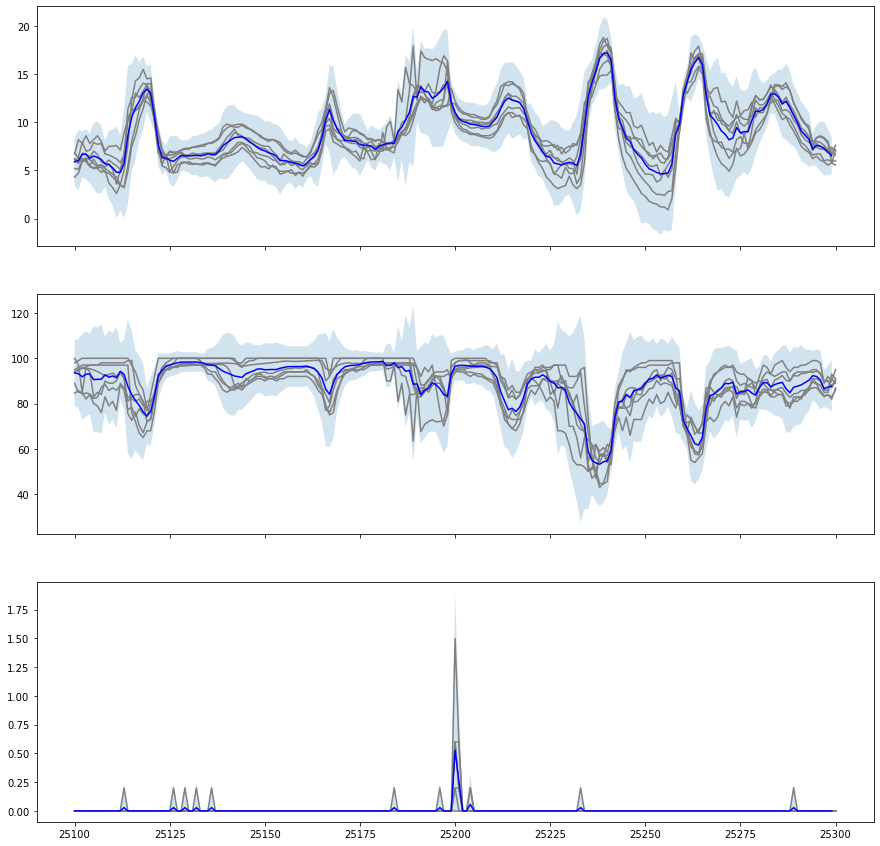

In [12]:
fig, ax = plt.subplots(3,1,figsize=(15,15), sharex=True)
with open('/home/diego/weather-control/experiments/experimentoFINAL/data/dataset_zmodel.pickle','rb') as h:
    dfs = pickle.load(h)

for df in dfs:
    df.drop(df.columns.difference(['temperatura','precipitacion', 'hr']), axis=1, inplace=True)
    # Reescalar
    scaler = Escalador(Xmin=7, Xmax=100)
    df.hr = scaler.inverse_transform(df.hr.values)
    scaler = Escalador(Xmin=0, Xmax=19.7)
    df.precipitacion = scaler.inverse_transform(df.precipitacion.values)
    scaler = Escalador(Xmin=-6.54, Xmax=41.9)
    df.temperatura = scaler.inverse_transform(df.temperatura.values)

a=25100
b=25300 
    
df_temp = pd.DataFrame(columns=["media", "stdev", "indice"])
df_hr = pd.DataFrame(columns=["media", "stdev", "indice"])
df_rain = pd.DataFrame(columns=["media", "stdev", "indice"])

for i in range(a, b):
    v_t, v_hr, v_r = [],[],[]
    for df in dfs:
        try:
            v_t.append(df.loc[i, 'temperatura'])
            v_hr.append(df.loc[i, 'hr'])
            v_r.append(df.loc[i, 'precipitacion'])
        except KeyError:
            continue

    df_temp = df_temp.append(pd.Series([np.mean(v_t), np.std(v_t)], index=["media", "stdev"]), ignore_index=True)
    df_hr = df_hr.append(pd.Series([np.mean(v_hr), np.std(v_hr)], index=["media", "stdev"]), ignore_index=True)
    df_rain = df_rain.append(pd.Series([np.mean(v_r), np.std(v_r)], index=["media", "stdev"]), ignore_index=True)

df_temp.indice = range(a, b)
df_hr.indice = range(a, b)
df_rain.indice = range(a, b)
df_temp.set_index('indice', inplace=True)
df_rain.set_index('indice', inplace=True)
df_hr.set_index('indice', inplace=True)

estaciones = ["Villar de Torre", "Arenzana de Abajo35", "Arenzana de Abajo-1", "Arenzana de Abajo-2",
              "Badaran-El Hombro", "Somalcampo", "Villaverde", "Cordovin"]
for df in dfs:
    df = df.loc[a:b]
    ax[0].plot(df['temperatura'], c='gray')
    ax[1].plot(df['hr'], c='gray')
    ax[2].plot(df['precipitacion'], c='gray')

ax[0].plot(df_temp.media, c='blue')
ax[0].fill_between(df_temp.index, df_temp.media - 3 * df_temp.stdev, df_temp.media + 3 * df_temp.stdev, alpha=0.2)
ax[1].plot(df_hr.media, c='blue')
ax[1].fill_between(df_hr.index, df_hr.media - 3 * df_hr.stdev, df_hr.media + 3 * df_hr.stdev, alpha=0.2)
ax[2].plot(df_rain.media, c='blue')
ax[2].fill_between(df_rain.index, 0, df_rain.media + 3 * df_rain.stdev, alpha=0.2)    
plt.show()

In [3]:

raw_path = Path('/home/diego/weather-control/data/raw/sql-raw/raw.csv')
raw = pd.read_csv(raw_path, header=0, na_values='\0',sep=";")

ubicaciones = raw['ubicacion'].unique()
print(f"Ubicaciones disponibles {raw['ubicacion'].unique()}")

metricas = raw['metrica'].unique()
for ubicacion in tqdm(ubicaciones, desc='Ubicaciones', leave=True):
    dfs = []
    for metrica in tqdm(metricas, desc='Metricas', leave=True):
        a = raw.loc[(raw.ubicacion == ubicacion) & (raw.metrica == metrica), ['fecha', 'valor']]
        if metrica == 1:
            a.rename(columns = {'valor':'temperatura'}, inplace = True)
        if metrica == 6:
            a.rename(columns = {'valor':'hr'}, inplace = True)
        if metrica == 11:
            a.rename(columns = {'valor':'precipitacion'}, inplace = True)
        dfs.append(a)
        dfs.sort(key=lambda x: len(x), reverse=True)
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on='fecha',  how='outer'), dfs)
df_merged.head()

Ubicaciones disponibles [  25   28   35  102 1289 2082 2684 2698 2706 2922 2966 3002 3003 3005]


Ubicaciones: 100%|██████████| 14/14 [00:01<00:00,  7.60it/s]


,fecha,temperatura,hr,precipitacion
0,2020-08-04 12:18:00,21.3,53.0,0.0
1,2020-08-04 12:30:00,21.3,52.0,0.0
2,2020-08-04 12:45:00,22.2,50.0,0.0
3,2020-08-04 13:00:00,21.8,50.0,0.0
4,2020-08-04 13:15:00,21.9,53.0,0.0


fecha            0
hr               0
precipitacion    0
temperatura      7
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63425 entries, 2018-01-01 00:00:00 to 2021-08-15 00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fecha          63425 non-null  datetime64[ns]
 1   hr             63425 non-null  float64       
 2   precipitacion  63425 non-null  float64       
 3   temperatura    63418 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.4 MB
None
hr               0
precipitacion    0
temperatura      0
fecha            0
dtype: int64


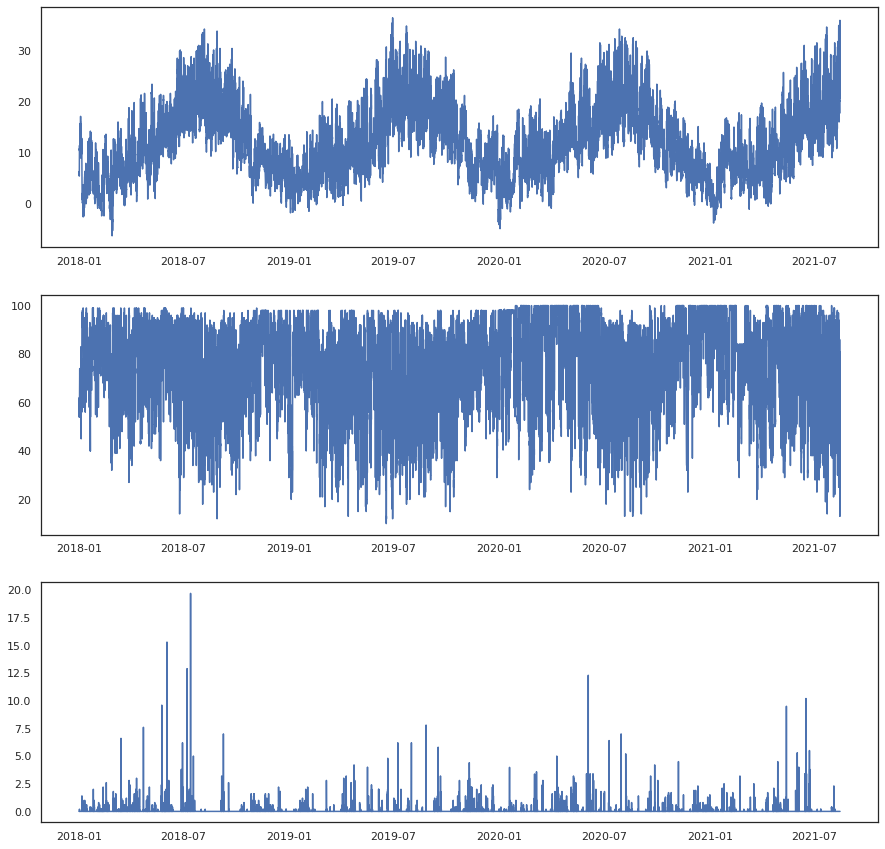

In [120]:
# Ubicaciion 25
df_path = Path("/home/diego/weather-control/docs/csv_tfm/25.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)
print(df.isna().sum())
print(df.info())
fechas = df['fecha']
df.drop(columns=['fecha'], inplace=True)
imp_mean = IterativeImputer(random_state=0)
idf = imp_mean.fit_transform(df)
idf = pd.DataFrame(idf, columns=df.columns)
df['temperatura'] = idf['temperatura'].values
df['hr'] = idf['hr'].values
df['precipitacion'] = idf['precipitacion'].values
df['fecha'] = fechas
print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

In [7]:
df.describe()

,hr,precipitacion,temperatura
count,190341.000000,187531.000000,186209.000000
mean,83.022163,0.009738,13.063991
std,20.933433,0.105523,7.690309
min,10.780000,0.000000,-147.130000
25%,67.260000,0.000000,7.330000
50%,95.340000,0.000000,12.350000
75%,100.000000,0.000000,17.940000
max,100.000000,17.400000,194.580000


fecha             0
hr                0
precipitacion     0
temperatura      14
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63446 entries, 2018-01-01 00:00:00 to 2021-08-15 00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fecha          63446 non-null  datetime64[ns]
 1   hr             63446 non-null  float64       
 2   precipitacion  63446 non-null  float64       
 3   temperatura    63432 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.4 MB
None
hr               0
precipitacion    0
temperatura      0
fecha            0
dtype: int64


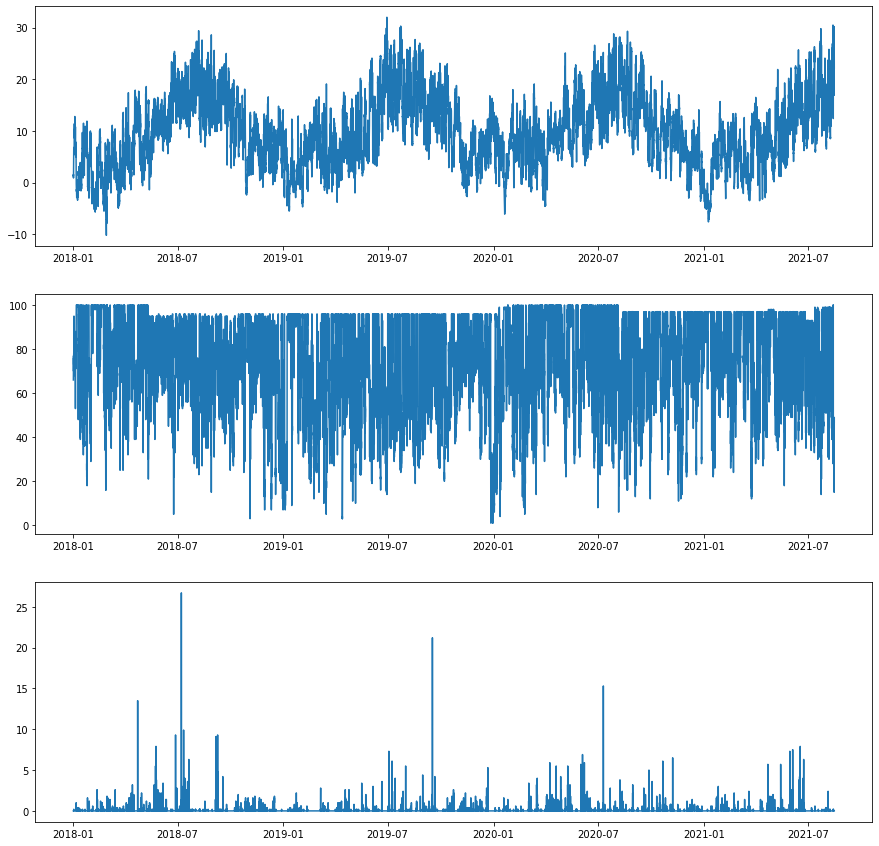

In [8]:
# Ubicaciion 28
df_path = Path("/home/diego/weather-control/docs/csv_tfm/28.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)
print(df.isna().sum())
print(df.info())

fechas = df['fecha']
df.drop(columns=['fecha'], inplace=True)
imp_mean = IterativeImputer(random_state=0)
idf = imp_mean.fit_transform(df)
idf = pd.DataFrame(idf, columns=df.columns)
df['temperatura'] = idf['temperatura'].values
df['hr'] = idf['hr'].values
df['precipitacion'] = idf['precipitacion'].values
df['fecha'] = fechas
print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

In [9]:
df.describe()

,hr,precipitacion,temperatura
count,63446.000000,63446.000000,63446.000000
mean,73.789788,0.039196,9.451352
std,21.546810,0.299674,6.723298
min,1.000000,0.000000,-10.200000
25%,60.000000,0.000000,4.600000
50%,77.000000,0.000000,9.000000
75%,95.000000,0.000000,13.800000
max,100.000000,26.700000,32.000000


fecha             0
precipitacion     0
temperatura      22
hr               22
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63441 entries, 2018-01-01 00:00:00 to 2021-08-15 00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fecha          63441 non-null  datetime64[ns]
 1   precipitacion  63441 non-null  float64       
 2   temperatura    63419 non-null  float64       
 3   hr             63419 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.4 MB
None
precipitacion    0
temperatura      0
hr               0
fecha            0
dtype: int64


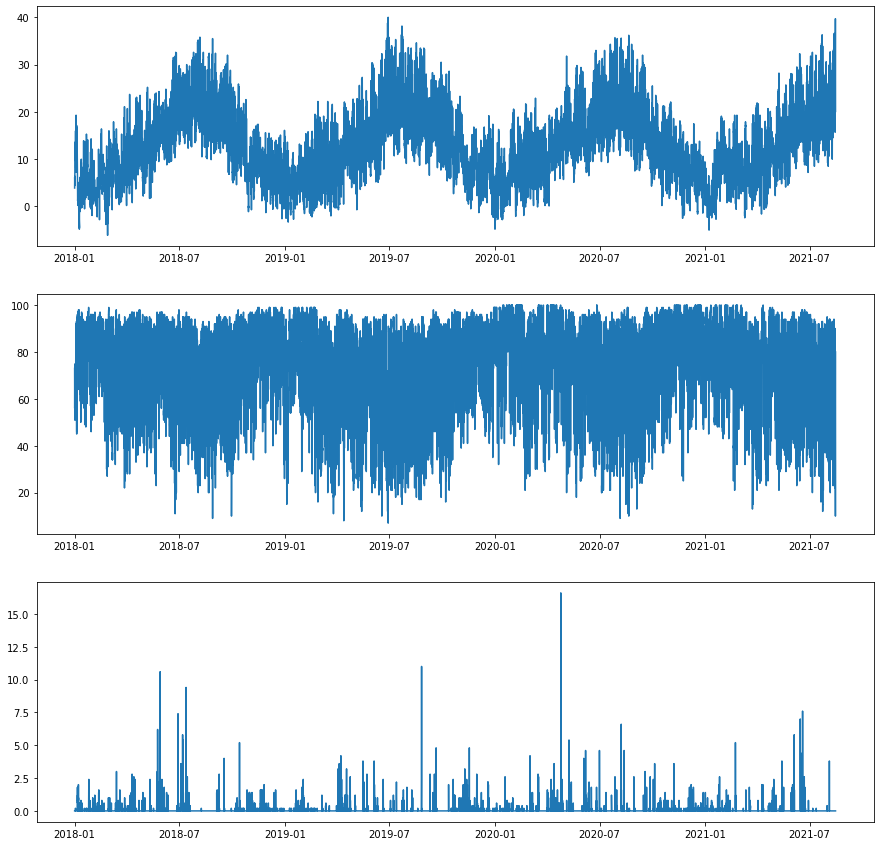

In [10]:
# Ubicaciion 35
df_path = Path("/home/diego/weather-control/docs/csv_tfm/35.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())
print(df.info())
#print(df[df.isna().any(axis=1)])
nanas=df[df.isna().any(axis=1)].index

fechas = df['fecha']
df.drop(columns=['fecha'], inplace=True)
imp_mean = IterativeImputer(random_state=0)
idf = imp_mean.fit_transform(df)
idf = pd.DataFrame(idf, columns=df.columns)
df['temperatura'] = idf['temperatura'].values
df['hr'] = idf['hr'].values
df['precipitacion'] = idf['precipitacion'].values
df['fecha'] = fechas
print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])


In [11]:
df.describe()

,precipitacion,temperatura,hr
count,63441.000000,63441.000000,63441.000000
mean,0.032181,12.629640,72.423957
std,0.232167,7.493406,19.541687
min,0.000000,-6.100000,7.000000
25%,0.000000,7.000000,59.000000
50%,0.000000,11.900000,77.000000
75%,0.000000,17.400000,89.000000
max,16.600000,40.000000,100.000000


fecha               0
hr                  3
precipitacion    2813
temperatura      4135
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190344 entries, 2018-01-01 00:00:02 to 2019-12-31 21:20:00
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   fecha          190344 non-null  datetime64[ns]
 1   hr             190341 non-null  float64       
 2   precipitacion  187531 non-null  float64       
 3   temperatura    186209 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.3 MB
None


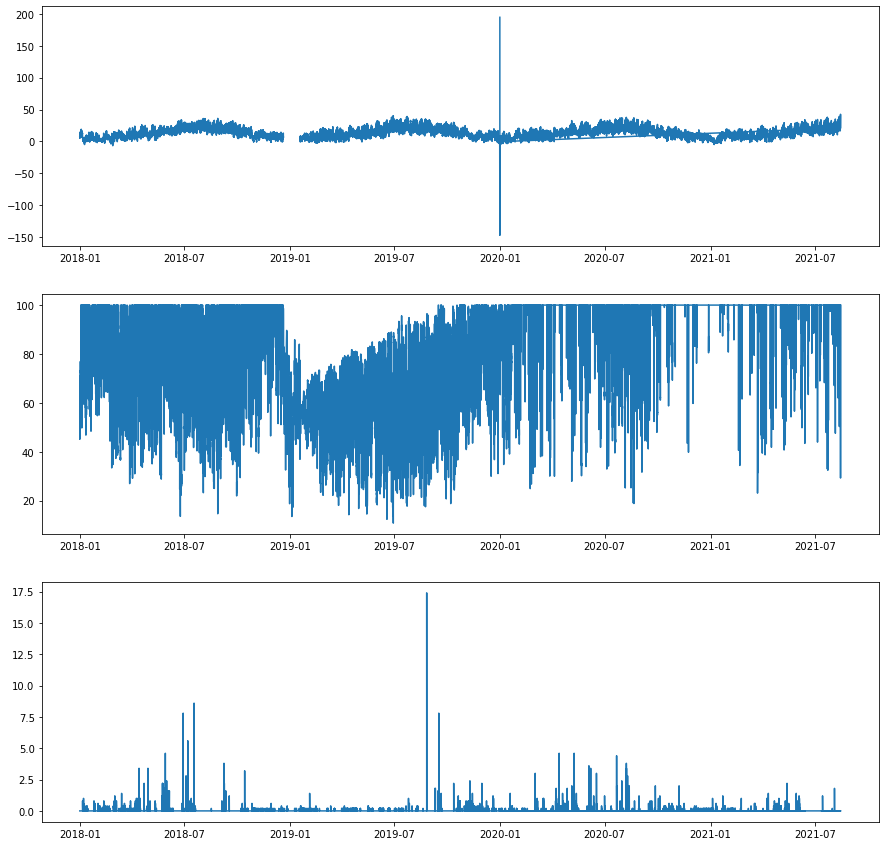

In [12]:
# Ubicaciion 102
df_path = Path("/home/diego/weather-control/docs/csv_tfm/102.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)
print(df.isna().sum())
print(df.info())
fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

In [13]:
df.describe()

,hr,precipitacion,temperatura
count,190341.000000,187531.000000,186209.000000
mean,83.022163,0.009738,13.063991
std,20.933433,0.105523,7.690309
min,10.780000,0.000000,-147.130000
25%,67.260000,0.000000,7.330000
50%,95.340000,0.000000,12.350000
75%,100.000000,0.000000,17.940000
max,100.000000,17.400000,194.580000


fecha             0
temperatura       0
hr                0
precipitacion    31
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31024 entries, 2018-01-01 00:00:00 to 2021-08-15 00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fecha          31024 non-null  datetime64[ns]
 1   temperatura    31024 non-null  float64       
 2   hr             31024 non-null  float64       
 3   precipitacion  30993 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.2 MB
None
temperatura      0
hr               0
precipitacion    0
fecha            0
dtype: int64


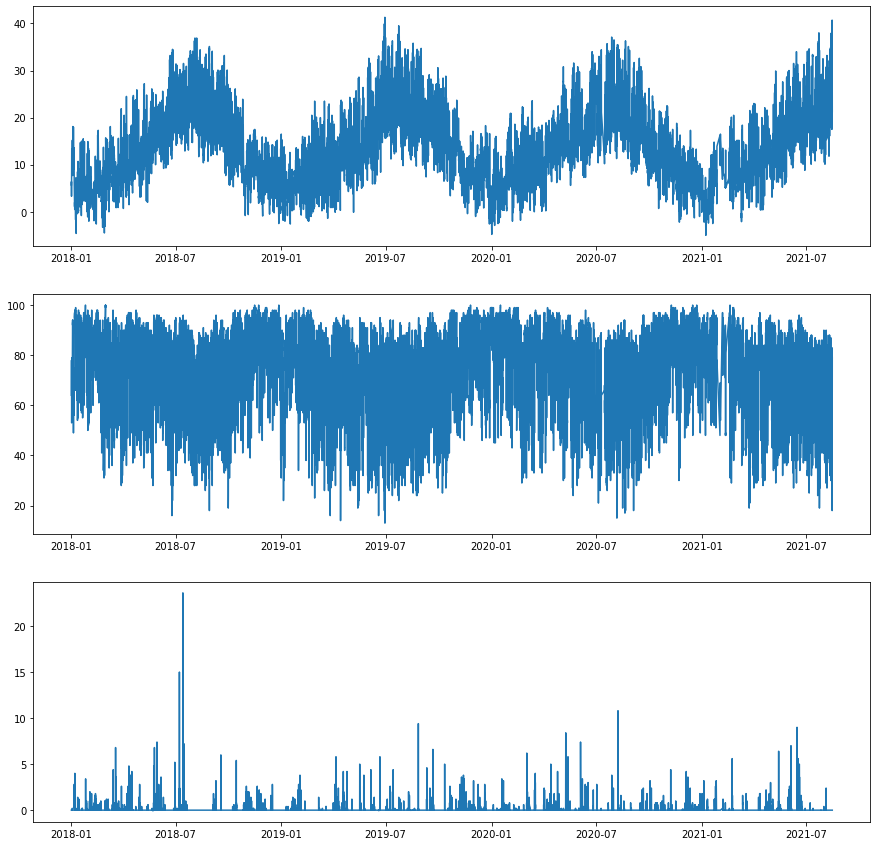

In [15]:
df_path = Path("/home/diego/weather-control/docs/csv_tfm/1289.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
# borrar las tres ultimas
df = df.iloc[:-3,:]
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())
print(df.info())

fechas = df['fecha']
df.drop(columns=['fecha'], inplace=True)

imp_mean = IterativeImputer(random_state=0)
idf = imp_mean.fit_transform(df)
idf = pd.DataFrame(idf, columns=df.columns)
df['temperatura'] = idf['temperatura'].values
df['hr'] = idf['hr'].values
df['precipitacion'] = idf['precipitacion'].values
df['fecha'] = fechas
print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

In [16]:
df.describe()

,temperatura,hr,precipitacion
count,31024.000000,31024.000000,31024.000000
mean,13.304977,72.334547,0.055020
std,7.773322,17.741647,0.373739
min,-5.000000,13.000000,-0.080330
25%,7.500000,60.000000,0.000000
50%,12.600000,76.000000,0.000000
75%,18.300000,87.000000,0.000000
max,41.300000,100.000000,23.600000


temperatura      1257
hr               1257
precipitacion    1257
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113944 entries, 2018-04-17 08:45:00 to 2021-08-15 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   temperatura    112687 non-null  float64
 1   hr             112687 non-null  float64
 2   precipitacion  112687 non-null  float64
dtypes: float64(3)
memory usage: 3.5 MB
None


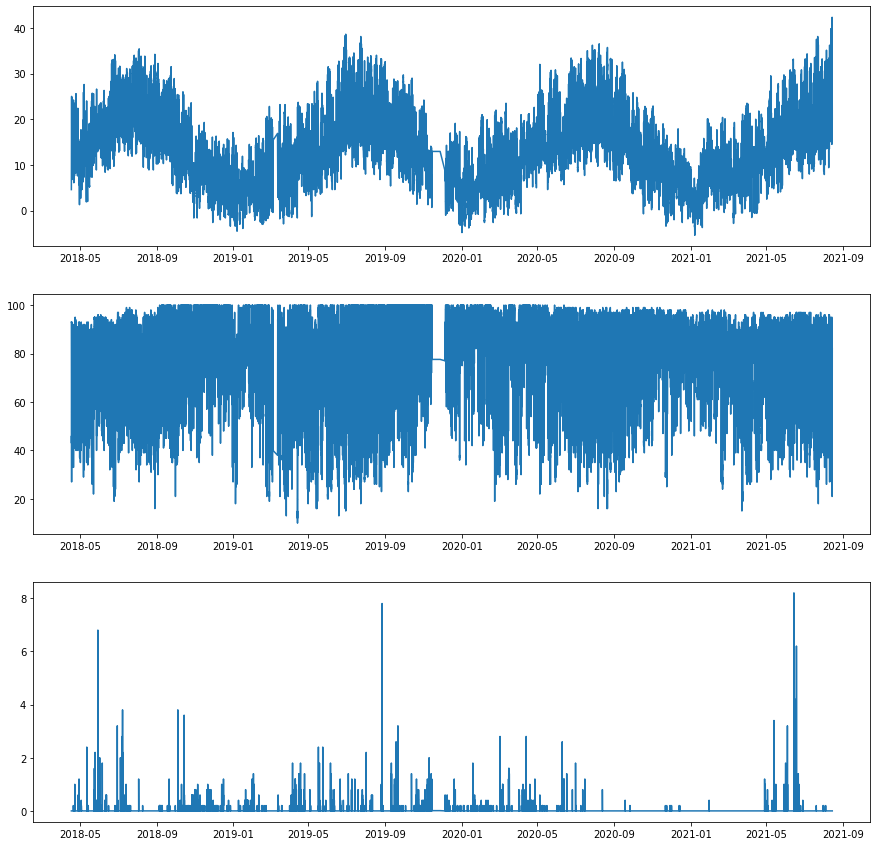

In [21]:
# Ubicaciion 2082
df_path = Path("/home/diego/weather-control/docs/csv_tfm/2082.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df = df.iloc[3000:]
#outliers de temperatura -15.5 los elimino
df.loc[df['temperatura'] == df['temperatura'].min(),['hr','precipitacion','temperatura']] = np.nan

df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
fechas = df['fecha']
df.set_index('fecha', drop=True, inplace=True)


print(df.isna().sum())
print(df.info())


# fig, ax = plt.subplots(3,1,figsize=(15,15))
# ax[0].plot(df['temperatura'])
# ax[1].plot(df['hr'])
# ax[2].plot(df['precipitacion'])
# plt.show()

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
idf = imp_mean.fit_transform(df.values)
idf = pd.DataFrame(idf, columns=df.columns)
df['temperatura'] = idf['temperatura'].values
df['precipitacion'] = idf['precipitacion'].values
df['hr'] = idf['hr'].values

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()
# # df['fecha'] = df.index
# # df = precipitacionmenorzero(df)
# # df.to_csv(df_path, header=True, index=False, na_rep="NaN")

In [22]:
df.head()

,temperatura,hr,precipitacion
fecha,,,
2018-04-17 08:45:00,4.6,93.0,0.0
2018-04-17 09:00:00,5.9,93.0,0.0
2018-04-17 09:15:00,7.2,86.0,0.0
2018-04-17 09:45:00,10.7,73.0,0.0
2018-04-17 10:00:00,11.4,67.0,0.0


                     temperatura     hr  precipitacion
fecha                                                 
2019-05-29 09:50:00        10.71  74.79            0.0
2019-05-29 10:00:00        10.51  77.29            0.0
2019-05-29 10:10:00        10.40  77.42            0.0
2019-05-29 10:20:00        10.57  75.40            0.0
2019-05-29 10:30:00        10.59  77.03            0.0
...                          ...    ...            ...
2021-08-14 23:20:00        20.58  78.81            0.0
2021-08-14 23:30:00        20.40  80.77            0.0
2021-08-14 23:40:00        20.20  80.95            0.0
2021-08-14 23:50:00        20.25  80.71            0.0
2021-08-15 00:00:00        19.77  83.26            0.0

[116425 rows x 3 columns]
temperatura      0
hr               0
precipitacion    0
dtype: int64


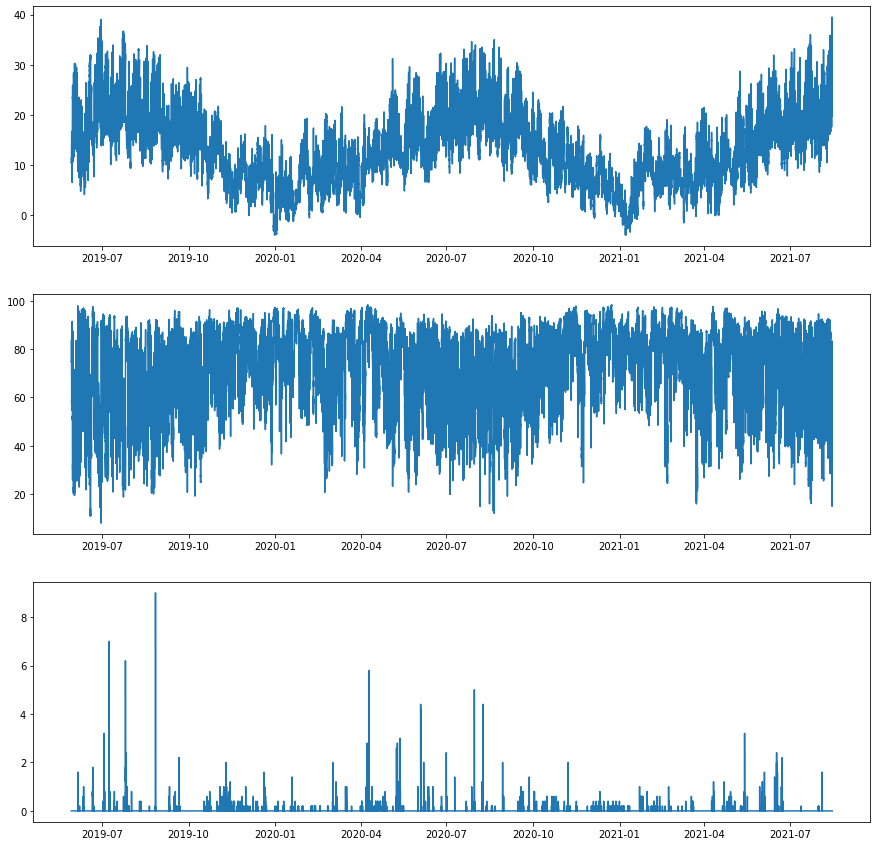

In [24]:
# %%
# Ubicaciion 2684
df_path = Path("/home/diego/weather-control/docs/csv_tfm/2684.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df['fecha'] = df['fecha'].dt.strftime('%Y-%m-%d %H:%M')
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M')
df.set_index('fecha', drop=True, inplace=True)
print(df)
print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()



In [27]:
df.describe()

,temperatura,hr,precipitacion
count,116425.000000,116425.000000,116425.000000
mean,13.136101,71.675545,0.008163
std,7.180487,16.998937,0.088040
min,-4.000000,7.940000,0.000000
25%,7.760000,60.410000,0.000000
50%,12.510000,75.320000,0.000000
75%,17.620000,85.220000,0.000000
max,39.470000,98.260000,9.000000


fecha            0
temperatura      0
hr               0
precipitacion    0
dtype: int64


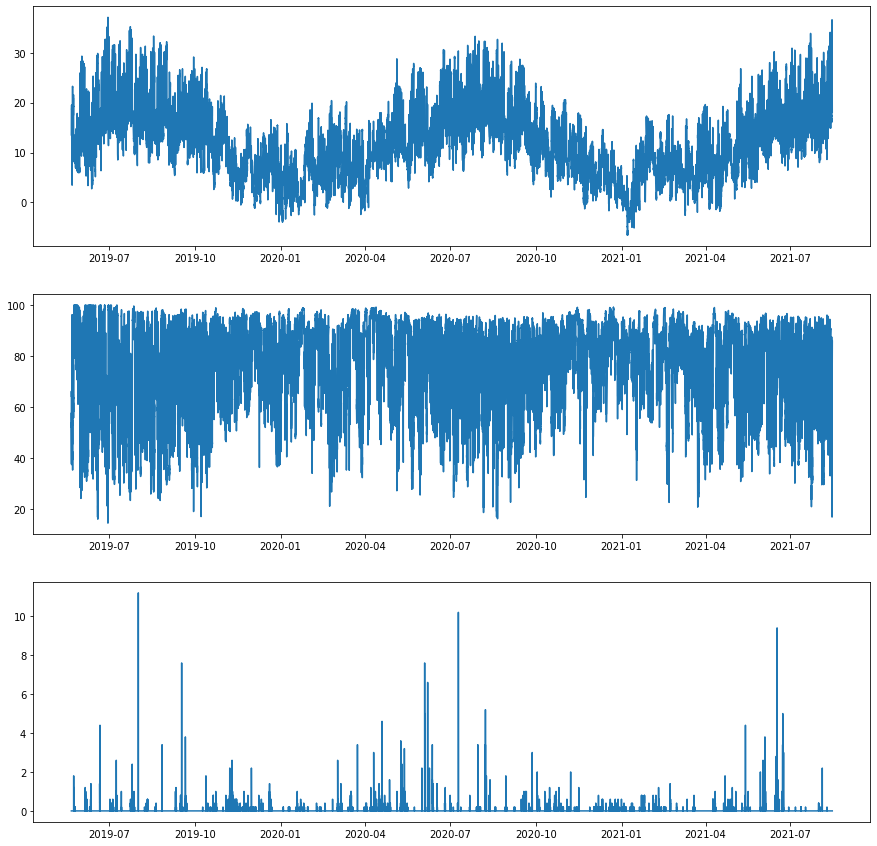

In [32]:
# %%
# Ubicaciion 2698
df_path = Path("/home/diego/weather-control/docs/csv_tfm/2698.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df['fecha'] = df['fecha'].dt.strftime('%Y-%m-%d %H:%M')
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()


In [33]:
df

,fecha,temperatura,hr,precipitacion
fecha,,,,
2019-05-21 11:00:00,2019-05-21 11:00:00,13.53,64.29,0.0
2019-05-21 11:10:00,2019-05-21 11:10:00,13.57,66.27,0.0
2019-05-21 11:20:00,2019-05-21 11:20:00,13.82,63.18,0.0
2019-05-21 11:30:00,2019-05-21 11:30:00,13.85,64.51,0.0
2019-05-21 11:40:00,2019-05-21 11:40:00,14.18,59.10,0.0
...,...,...,...,...
2021-08-14 23:20:00,2021-08-14 23:20:00,18.86,83.56,0.0
2021-08-14 23:30:00,2021-08-14 23:30:00,18.71,84.21,0.0
2021-08-14 23:40:00,2021-08-14 23:40:00,18.55,84.36,0.0


fecha             0
precipitacion     0
temperatura      83
hr               83
dtype: int64
                                  fecha  precipitacion  temperatura    hr
fecha                                                                    
2019-09-13 10:30:00 2019-09-13 10:30:00            0.0         18.7  64.0
2019-09-13 10:45:00 2019-09-13 10:45:00            0.0         19.1  64.0
2019-09-13 11:00:00 2019-09-13 11:00:00            0.0         19.9  60.0
2019-09-13 11:15:00 2019-09-13 11:15:00            0.0         19.1  62.0
2019-09-13 11:30:00 2019-09-13 11:30:00            0.0         20.0  60.0
...                                 ...            ...          ...   ...
2021-08-14 23:00:00 2021-08-14 23:00:00            0.0         19.6  80.0
2021-08-14 23:15:00 2021-08-14 23:15:00            0.0         19.3  82.0
2021-08-14 23:30:00 2021-08-14 23:30:00            0.0         19.2  82.0
2021-08-14 23:45:00 2021-08-14 23:45:00            0.0         18.7  83.0
2021-08-15 00:00:00

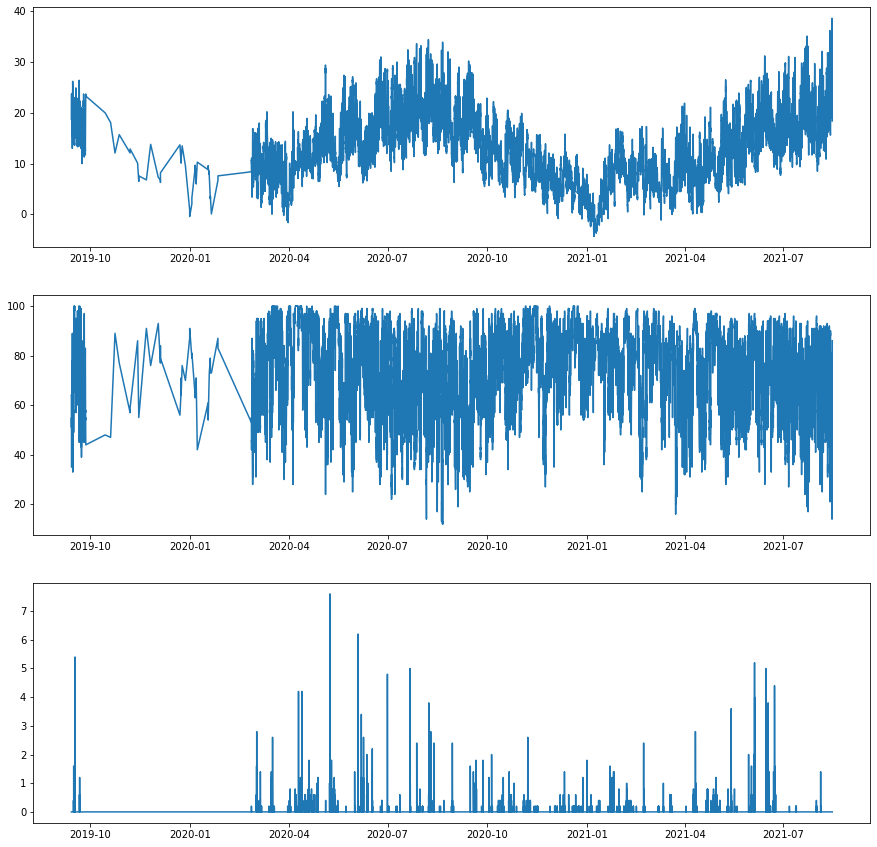

precipitacion    0
temperatura      0
hr               0
fecha            0
dtype: int64


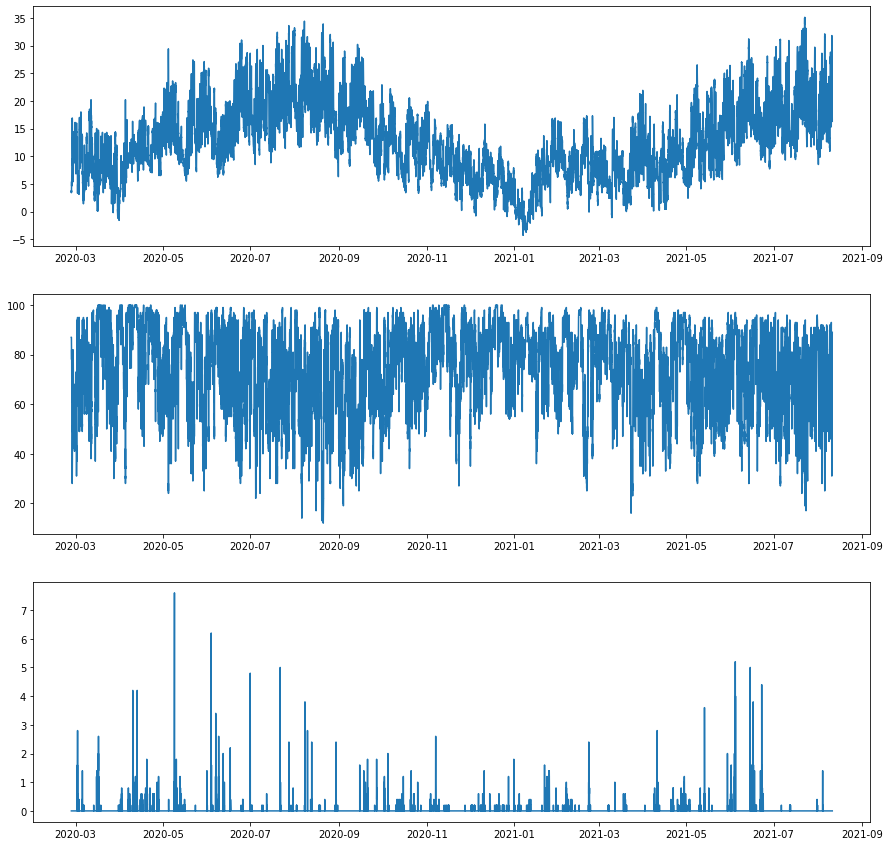

In [39]:
# %%
# Ubicaciion 2706
df_path = Path("/home/diego/weather-control/docs/csv_tfm/2706.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
# borrar las 25 ultimas
df = df.iloc[:-15,:]

df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())
print(df)

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

df=df.loc[(df['fecha'] > "2020-02-27") & (df['fecha'] <= "2021-08-11") , :]
fechas = df['fecha']
df.drop(columns=['fecha'], inplace=True)
imp_mean = IterativeImputer(random_state=0)
idf = imp_mean.fit_transform(df)
idf = pd.DataFrame(idf, columns=df.columns)
df['temperatura'] = idf['temperatura'].values
df['hr'] = idf['hr'].values
df['precipitacion'] = idf['precipitacion'].values
df['fecha'] = fechas

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df.iloc[:].loc[:,'temperatura'])
ax[1].plot(df.iloc[:].loc[:,'hr'])
ax[2].plot(df.iloc[:].loc[:,'precipitacion'])

print(df.isna().sum())


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50403 entries, 2020-02-27 00:15:00 to 2021-08-11 00:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   precipitacion  50403 non-null  float64       
 1   temperatura    50403 non-null  float64       
 2   hr             50403 non-null  float64       
 3   fecha          50403 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 MB


fecha            0
temperatura      0
hr               0
precipitacion    0
dtype: int64


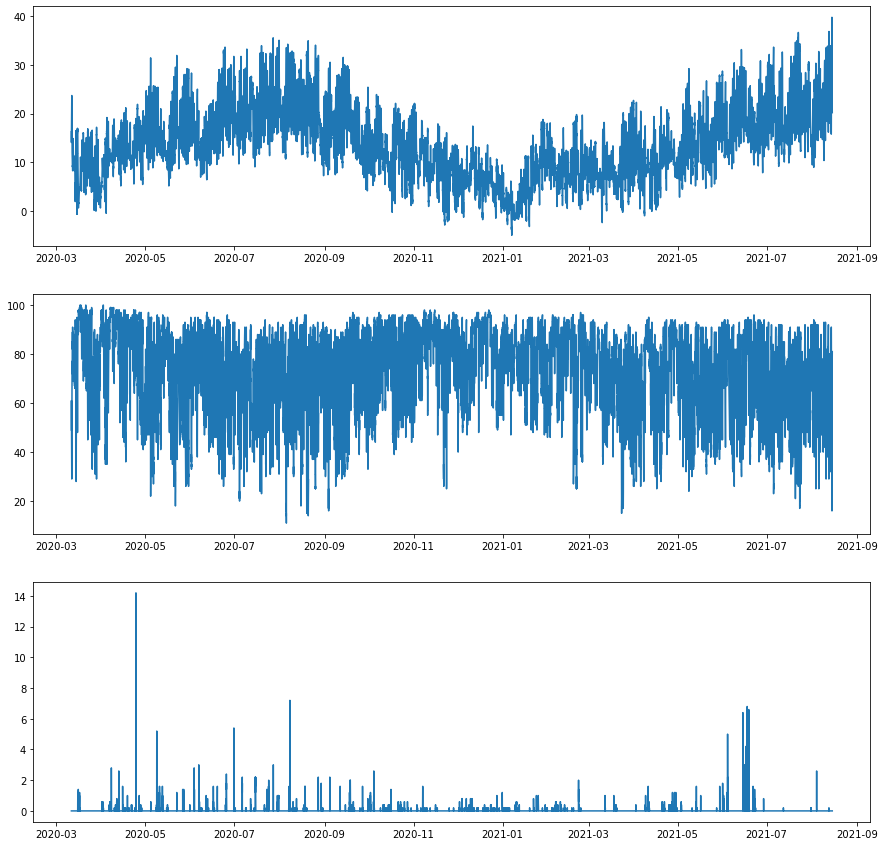

In [40]:
# %%
# Ubicaciion 2922
df_path = Path("/home/diego/weather-control/docs/csv_tfm/2922.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()


In [43]:
df.describe()

,temperatura,hr,precipitacion
count,49834.000000,49834.000000,49834.000000
mean,13.480610,72.934081,0.019878
std,7.202444,17.459568,0.169177
min,-4.900000,11.000000,0.000000
25%,8.300000,61.000000,0.000000
50%,12.800000,76.000000,0.000000
75%,18.000000,87.000000,0.000000
max,39.700000,100.000000,14.200000


fecha             0
temperatura       0
hr                0
precipitacion    85
dtype: int64


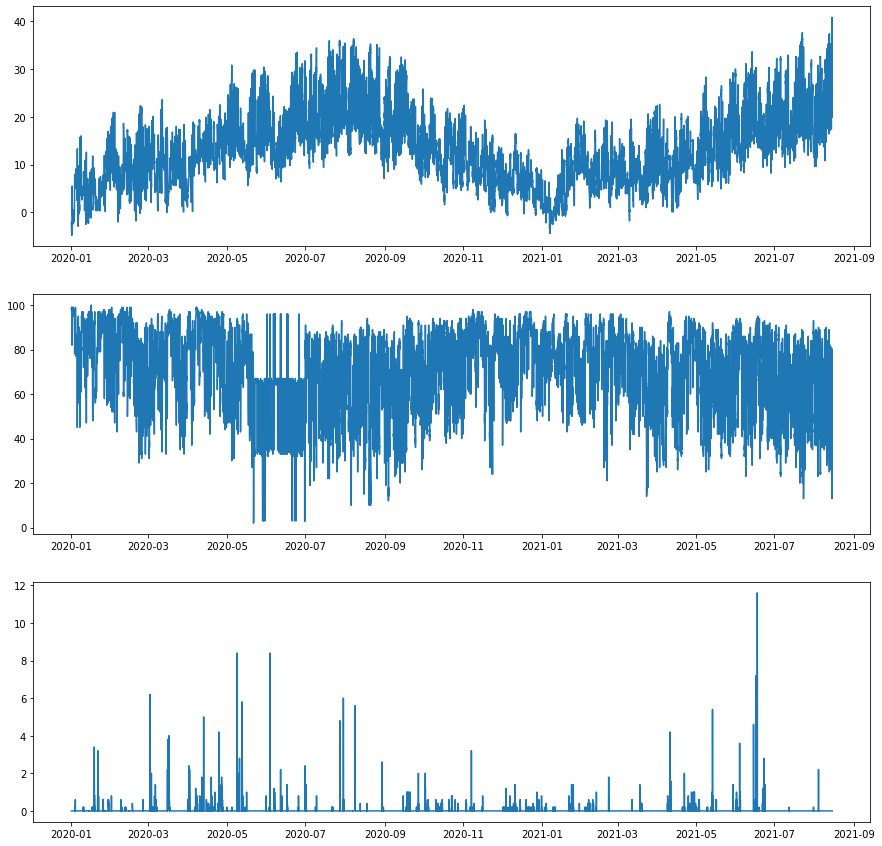

fecha            0
temperatura      0
hr               0
precipitacion    0
dtype: int64
DatetimeIndex([], dtype='datetime64[ns]', name='fecha', freq=None)


In [52]:
# %%
# Ubicaciion 2966
df_path = Path("/home/diego/weather-control/docs/csv_tfm/2966.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
# borrar las 8 ultimas
df = df.iloc[:-8,:]
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

# # hr cosas raras en <9000
df=df.loc[(df['fecha'] >= "2020-08-10")  , :]
print(df.isna().sum())
print(df.loc[df.precipitacion.isna()].index)

In [57]:
df.describe()

,fecha,precipitacion,temperatura,hr
fecha,,,,
2020-08-04 13:30:00,2020-08-04 13:30:00,0.0,31.6,30.0
2020-08-04 13:45:00,2020-08-04 13:45:00,0.0,21.4,49.0
2020-08-04 14:00:00,2020-08-04 14:00:00,0.0,21.3,50.0
2020-08-04 14:15:00,2020-08-04 14:15:00,0.0,22.1,47.0
2020-08-04 14:30:00,2020-08-04 14:30:00,0.0,22.1,50.0
...,...,...,...,...
2021-08-14 23:00:00,2021-08-14 23:00:00,0.0,20.3,79.0
2021-08-14 23:15:00,2021-08-14 23:15:00,0.0,20.0,80.0
2021-08-14 23:30:00,2021-08-14 23:30:00,0.0,19.8,81.0


fecha            0
precipitacion    0
temperatura      1
hr               1
dtype: int64


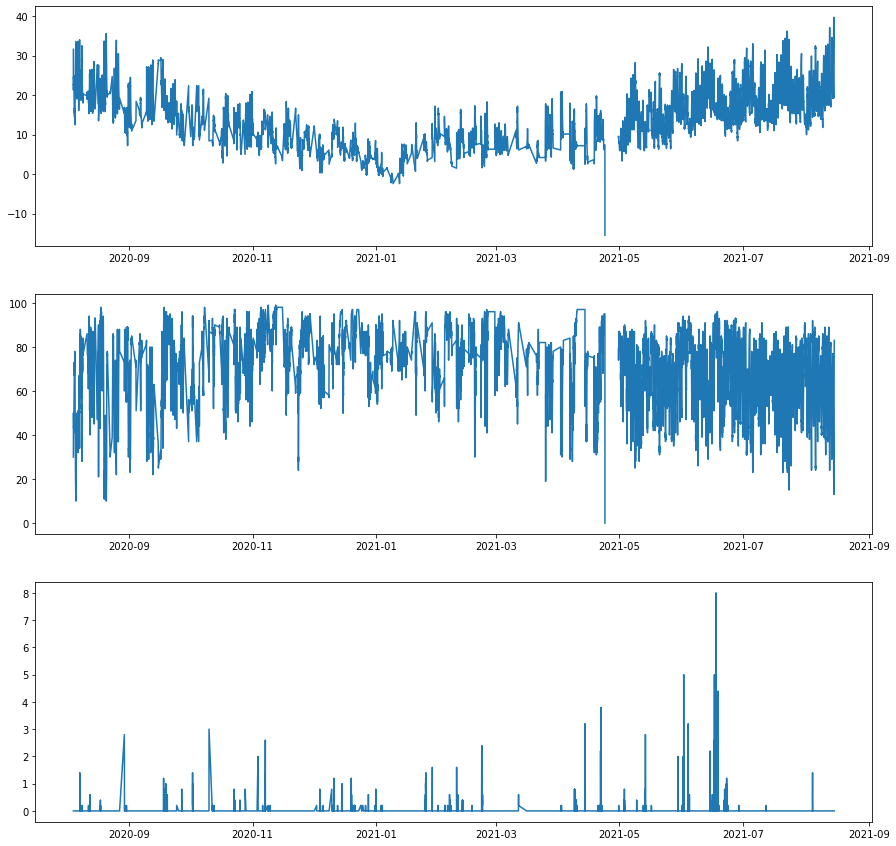

In [54]:
# %%
# Ubicaciion 3002
df_path = Path("/home/diego/weather-control/docs/csv_tfm/3002.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
# # borrar las 8 ultimas
# df = df.iloc[:-8,:]
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

In [58]:
df.describe()

,precipitacion,temperatura,hr
count,23329.000000,23328.000000,23328.000000
mean,0.012654,13.821596,70.682999
std,0.139287,6.997825,17.030195
min,0.000000,-15.500000,0.000000
25%,0.000000,8.400000,60.000000
50%,0.000000,13.500000,74.000000
75%,0.000000,18.000000,84.000000
max,8.000000,39.700000,99.000000


fecha            0
temperatura      0
hr               0
precipitacion    0
dtype: int64


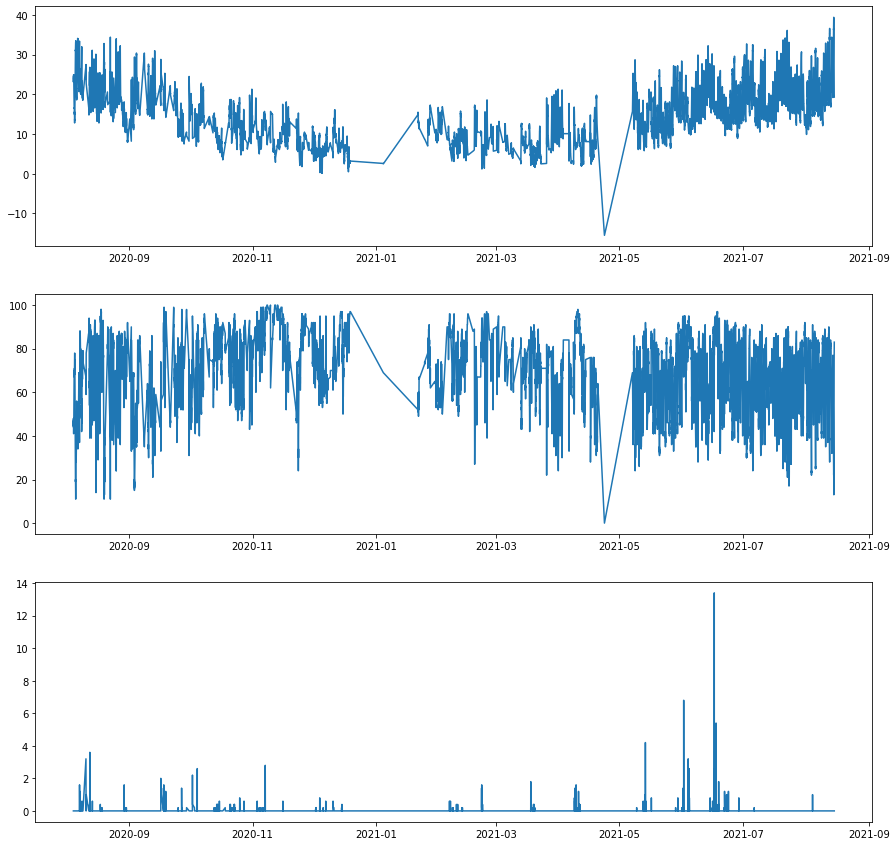

In [59]:
# %%
# Ubicaciion 3003
df_path = Path("/home/diego/weather-control/docs/csv_tfm/3003.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
# # borrar las 8 ultimas
# df = df.iloc[:-8,:]
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

In [62]:
df.describe()

,temperatura,hr,precipitacion
count,22687.000000,22687.000000,22687.000000
mean,14.261859,69.239785,0.011751
std,6.743290,17.194750,0.150796
min,-15.500000,0.000000,0.000000
25%,9.000000,58.000000,0.000000
50%,13.700000,72.000000,0.000000
75%,18.200000,82.000000,0.000000
max,39.400000,100.000000,13.400000


fecha            0
temperatura      0
hr               0
precipitacion    0
dtype: int64


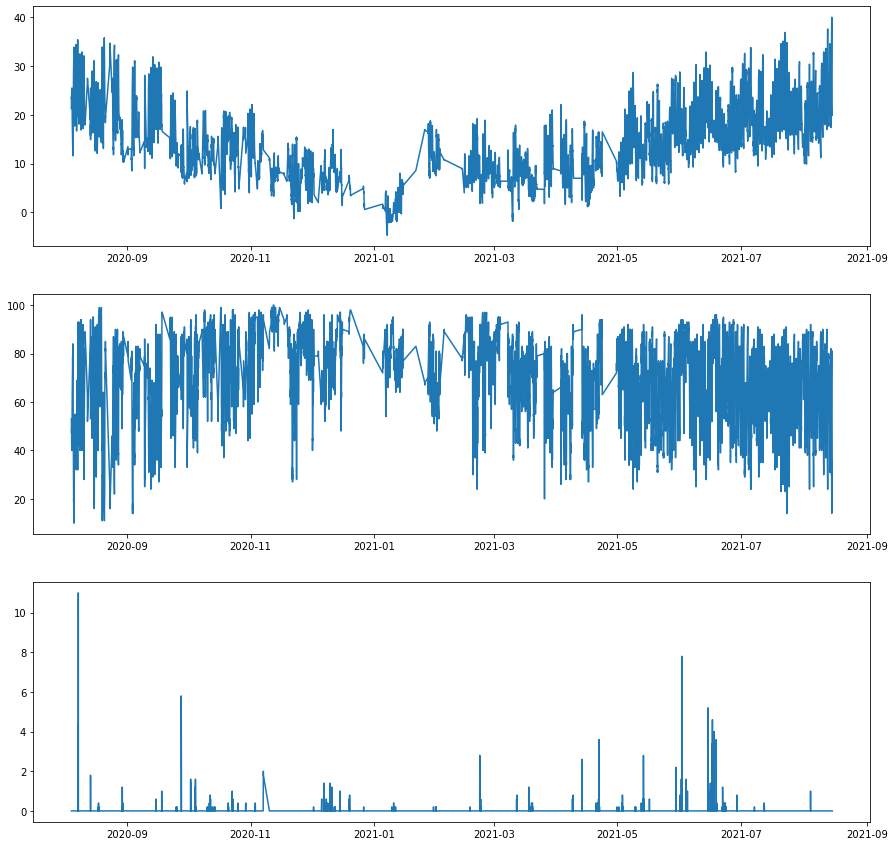

In [63]:
# %%
# Ubicaciion 3005
df_path = Path("/home/diego/weather-control/docs/csv_tfm/3005.csv")
df = pd.read_csv(df_path, na_values="NaN", header=0)
# # borrar las 8 ultimas
# df = df.iloc[:-8,:]
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df.set_index('fecha', drop=False, inplace=True)

print(df.isna().sum())

fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(df['temperatura'])
ax[1].plot(df['hr'])
ax[2].plot(df['precipitacion'])
plt.show()

In [65]:
df

,fecha,temperatura,hr,precipitacion
fecha,,,,
2020-08-04 12:18:00,2020-08-04 12:18:00,21.3,53.0,0.0
2020-08-04 12:30:00,2020-08-04 12:30:00,21.3,52.0,0.0
2020-08-04 12:45:00,2020-08-04 12:45:00,22.2,50.0,0.0
2020-08-04 13:00:00,2020-08-04 13:00:00,21.8,50.0,0.0
2020-08-04 13:15:00,2020-08-04 13:15:00,21.9,53.0,0.0
...,...,...,...,...
2021-08-14 23:00:00,2021-08-14 23:00:00,21.0,77.0,0.0
2021-08-14 23:15:00,2021-08-14 23:15:00,20.6,78.0,0.0
2021-08-14 23:30:00,2021-08-14 23:30:00,20.4,79.0,0.0
